<a href="https://colab.research.google.com/github/aCStandke/ReinforcementLearning/blob/main/ActorCriticAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actor-Critic 

Actor-Critic methods are [TD learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function.

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state. A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the actor that proposes a set of possible actions given a state, and the estimated value function is referred to as the critic, which evaluates actions taken by the actor based on the given policy.




# Importing and Setting up the Lunar Lander environment

In [1]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 14.0 MB/s 


In [2]:
import gym.envs.box2d.lunar_lander as lander
env = lander.LunarLanderContinuous()

In [3]:
!sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [4]:
import collections
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers

In [5]:
# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

# Building Actor Critic Model

The Actor and Critic will be modeled using one neural network that generates the action probabilities and critic value respectively. Meaning that θ<sub>k</sub> is the only paramater.

The paper [Actor-Critic Algorithms](https://proceedings.neurips.cc/paper/1999/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) has another paramater for the critic z<sub>k</sub> which represents [Sutton's eligibility trace](https://paperswithcode.com/method/eligibility-trace).


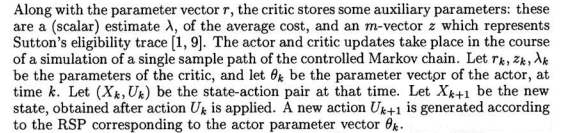





In [6]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions, 
      num_hidden_units):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs):
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [7]:
num_actions = 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

# Training

To train the agent, you will follow these steps:
1.   Run the agent on the environment to collect training data per episode
2.   Compute expected return at each time step.
3.   Compute the loss for the combined actor-critic model.
4.   Compute gradients and update network parameters.
5.   Repeat 1-4 until either success criterion or max episodes has been reached.


###### Step 1


> As in supervised learning, in order to train the actor-critic model, you need to have training data. However, in order to collect such data, the model would need to be "run" in the environment.

> Training data is collected for each episode. Then at each time step, the model's forward pass will be run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

> The next action will be sampled from the action probabilities generated by the model, which would then be applied to the environment, causing the next state and reward to be generated.

> This process is implemented in the run_episode function, which uses TensorFlow operations so that it can later be compiled into a TensorFlow graph for faster training. Note that tf.TensorArrays were used to support Tensor iteration on variable length arrays.

In [9]:
# Wrap OpenAI Gym's 'env.step' call as an operation in a TensorFlow function.
# This allows it to be included in a TensforFlow graph

# python function
# action: np.ndarray
def env_step(action):
  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), np.array(reward, np.int32), np.array(done, np.int32))

'''
tf.numpy_function: wraps a python function and uses it as a TensorFlow op.
Given a python function func tf wraps this function as an op 
in a TensorFlow function. func must take numpy arrays as its arguments and
return numpy arrays as its outputs
'''
# tensorflow function
# action: tf.Tensor 
def tf_env_step(action):
  return tf.numpy_function(env_step, [action], [tf.float32, tf.int32, tf.int32])


In [10]:
# initial_step: tf.Tensor
# model: tf.keras.Model
# max_steps: int
def run_episode(initial_state, model, max_steps):
  '''
  tf.TensorArray: class that wraps dynamic-sized, per-time-step, write-once 
  Tensor arrays.This class is meant to be used with dynamic iteration primitives
  such as while_loop and map_fn.  It supports gradient back-propagation via 
  special "flow" control flow dependencies.
  '''
  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  for t in tf.range(max_steps):
    # convert state into a batched tensor (batch =1)
    '''tf.expand_dims: returns a tensor with a length 1 axis inserted at index axis'''
    state = tf.expand_dims(state, 0)

    # run the model, to get logits representing actions and the critic value
    action_logits_t, value = model(state)

    # sample from a categorical distribution the next action logits
    action = tf.random.categorical(action_logits_t, num_samples=1)[0, 0]
    # transform into action probablities
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])

    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)

    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  return action_probs, values, rewards